Importing the dataset into the local files


In [ ]:
import os
import urllib.request
urllib.request.urlretrieve('https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip', 'dogImages.zip')

('dogImages.zip', <http.client.HTTPMessage at 0x7f6e1dac4ad0>)

Unziping them


In [ ]:
!unzip '/content/dogImages.zip'

Streaming output truncated to the last 5000 lines.
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03417.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03418.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03421.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03423.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03424.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03425.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03426.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03428.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03429.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03430.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03431.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03432.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03433.jpg  
  inflating: dogImages/train/048.Chihuahua/Chihuahua_03434.jpg  
  inflating: dogImages/train/048.Chihua

Converting the dataset into an array

In [ ]:
import numpy as np
from glob import glob


dog_files = np.array(glob("/content/dogImages/*/*/*"))



Loading the pre-trained model VGG-16

In [ ]:
import torch
import torchvision.models as models


VGG16 = models.vgg16(pretrained=True)


use_cuda = torch.cuda.is_available()


if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


Data preprocessing: Data loading, augmentation and normalization

In [ ]:
from torchvision import datasets
from PIL import Image
import torchvision.transforms as transforms

data_dir = '/content/dogImages'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])


valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])

train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_data = datasets.ImageFolder(valid_dir,transform=valid_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)


trainloader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=20,shuffle=False)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=20,shuffle=False)
loaders_transfer = {'train':trainloader,
                  'valid':validloader,
                  'test':testloader}
data_transfer = {
    'train':trainloader
}

Model Transfering


In [ ]:
import torchvision.models as models
import torch.nn as nn
model_transfer = models.vgg11(pretrained=True)

for param in model_transfer.features.parameters():
    param.requires_grad = False

 

if use_cuda:
    model_transfer = model_transfer.cuda()
print(model_transfer)

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


Truncating images

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
model_transfer.classifier[6] = nn.Linear(4096,133,bias=True)

Choosing loss function and optimizer

In [ ]:
import torch.optim as optim


criterion_transfer = nn.CrossEntropyLoss()


optimizer_transfer = optim.SGD(model_transfer.parameters(), lr=0.001, momentum=0.9)

Defining the  algorithm of training model

In [ ]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
  
    valid_loss_min = np.inf 
    
    for epoch in range(1, n_epochs+1):
        
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
                model.to('cuda')
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            accuracy=0
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            logps = model(data)
            loss = criterion(logps, target)

            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
            
            
         
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss
    
    return model

Training the model

In [ ]:
# train the model
model_transfer = train(10, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')


model_transfer.load_state_dict(torch.load('model_transfer.pt'))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 1 	Training Loss: 2.432808 	Validation Loss: 0.765195
Validation loss decreased (inf --> 0.765195).  Saving model ...
Epoch: 2 	Training Loss: 1.430229 	Validation Loss: 0.652111
Validation loss decreased (0.765195 --> 0.652111).  Saving model ...
Epoch: 3 	Training Loss: 1.265896 	Validation Loss: 0.609843
Validation loss decreased (0.652111 --> 0.609843).  Saving model ...
Epoch: 4 	Training Loss: 1.206795 	Validation Loss: 0.534271
Validation loss decreased (0.609843 --> 0.534271).  Saving model ...
Epoch: 5 	Training Loss: 1.130319 	Validation Loss: 0.572297
Epoch: 6 	Training Loss: 1.083676 	Validation Loss: 0.547747
Epoch: 7 	Training Loss: 1.076562 	Validation Loss: 0.535638
Epoch: 8 	Training Loss: 1.035938 	Validation Loss: 0.509815
Validation loss decreased (0.534271 --> 0.509815).  Saving model ...
Epoch: 9 	Training Loss: 1.017861 	Validation Loss: 0.504724
Validation loss decreased (0.509815 --> 0.504724).  Saving model ...
Epoch: 10 	Training Loss: 0.956870 	Valida

<All keys matched successfully>

Model testing

In [ ]:

def test(loaders, model, criterion, use_cuda):

    
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        
        output = model(data)
        
        loss = criterion(output, target)
         
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        
        pred = output.data.max(1, keepdim=True)[1]
        
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.470162


Test Accuracy: 85% (716/836)


Testing our own images

In [ ]:


dog_files_short = np.array(glob("/content/my_dogs/*"))

class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].dataset.classes]

model_transfer.load_state_dict(torch.load('model_transfer.pt'))
def predict_breed(img_path):
    
    
    transform = transforms.Compose([transforms.Resize(255),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
    img = Image.open(img_path)
    img = transform(img)[:3,:,:].unsqueeze(0)
    if use_cuda:
        img = img.cuda()
        model_transfer.to('cuda')
        
    model_transfer.eval()
    idx = torch.argmax(model_transfer(img))
    return class_names[idx]


    output = model_transfer(img)
    
    pred = output.data.max(1, keepdim=True)[1]
    
    return pred
for i in dog_files_short:
    print(predict_breed(i))
    break


In [ ]:
predict_breed('/content/labrador-retriever-dog-breed-info.jpeg')

'Labrador retriever'

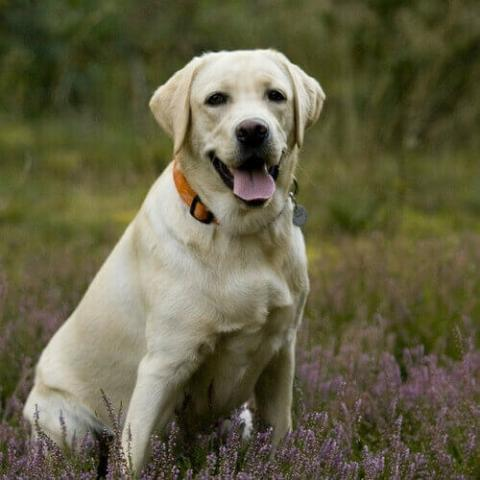

In [ ]:
predict_breed('/content/greyhound.jpeg')

'Italian greyhound'

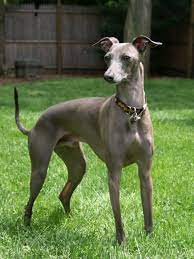

In [ ]:
predict_breed('/content/beagle-detail.jpeg')

'Beagle'

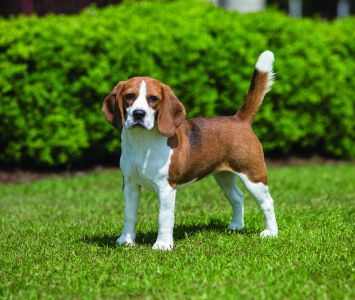